###Tensorflow-GPU

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.195502689000023
GPU (s):
0.08859647399998494
GPU speedup over CPU: 58x


###VAE Image Generate

####Dataset CelebA Download

In [ ]:
!pip install opendatasets

import opendatasets as od
od.download('https://www.kaggle.com/datasets/jessicali9530/celeba-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: reginaangelikasr
Your Kaggle Key: ··········


100%|██████████| 1.33G/1.33G [01:01<00:00, 23.3MB/s]


####Dataset VAE

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import errno
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from skimage.io import imread

def get_input(path):
    """get specific image from path"""
    img = imread(path)
    return img

def get_output(path, label_file = None):
    """get all the labels relative to the image of path"""
    img_id = path.split('/')[-1]
    labels = label_file.loc[img_id].values
    return labels

def preprocess_input(img):
    # convert between 0 and 1
    return img.astype('float32') / 127.5 -1

def image_generator(files, label_file, batch_size = 32):
    while True:

        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:

            input = get_input(input_path)
            input = preprocess_input(input)
            output = get_output(input_path, label_file = label_file)
            batch_input += [input]
            batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield batch_x, batch_y

def auto_encoder_generator(files, batch_size = 32):
    while True:
        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:
            input = get_input(input_path)
            input = preprocess_input(input)
            output = input
            batch_input += [input]
            batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield batch_x, batch_y

In [ ]:
attr = pd.read_csv('/content/celeba-dataset/list_attr_celeba.csv')
attr = attr.set_index('image_id')

# check if attribute successful loaded
attr.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,-0.777728,-0.466039,0.02501,-0.590857,-0.955113,-0.696849,-0.518408,-0.530935,-0.521498,-0.704016,...,-0.886979,-0.035839,-0.583196,-0.360866,-0.62215,-0.903079,-0.055129,-0.754066,-0.854570,0.547234
std,0.628602,0.884766,0.99969,0.806778,0.296241,0.717219,0.855135,0.847414,0.853255,0.710186,...,0.461811,0.999360,0.812333,0.932620,0.78290,0.429475,0.998482,0.656800,0.519338,0.836982
min,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,-1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.00000,-1.000000,1.000000,-1.000000,-1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.model_selection import train_test_split
IMG_NAME_LENGTH = 6
file_path = "/content/celeba-dataset/img_align_celeba/img_align_celeba/"
img_id = np.arange(1,len(attr.index)+1)
img_path = []
for i in range(len(img_id)):
    img_path.append(file_path + (IMG_NAME_LENGTH - len(str(img_id[i])))*'0' + str(img_id[i]) + '.jpg')

# pick 80% as training set and 20% as validation set
train_path = img_path[:int((0.8)*len(img_path))]
val_path = img_path[int((0.8)*len(img_path)):]
train_generator = auto_encoder_generator(train_path,32)
val_generator = auto_encoder_generator(val_path,32)

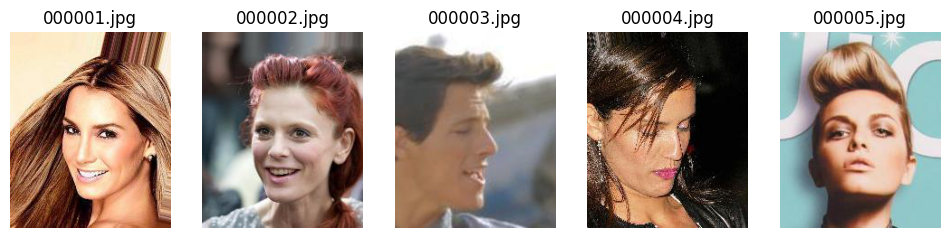

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    ax[i].imshow(get_input(img_path[i]))
    ax[i].axis('off')
    ax[i].set_title(img_path[i][-10:])
plt.show()

attr.iloc[:5]

<Axes: >

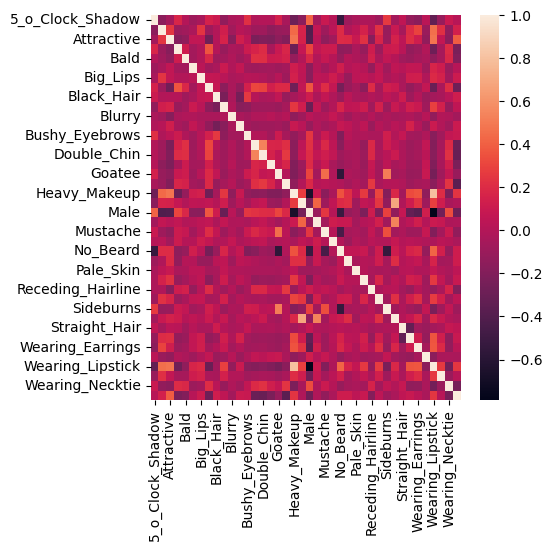

In [ ]:
plt.figure(figsize = (5,5))
sns.heatmap(attr.corr())

####Training VAE Dataset

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K
import random
from keras.losses import mse, binary_crossentropy
import os
import cv2
import zipfile
from PIL import Image
from matplotlib import image as mpimg
import shutil

In [ ]:
img_sample=get_input(img_path[0])

Instructions for updating:
Colocations handled automatically by placer.


encoder summary:
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 218, 178, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 218, 178, 32  128        ['conv2d_22[0][0]']              
 alization)                     )                                          

<ipython-input-12-6c2474acfb2e>:83: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vae_2.fit_generator(train_generator, steps_per_epoch = 4000, validation_data = val_generator, epochs=7, validation_steps= 500)


4000/4000 [==============================] - ETA: 0s - batch: 1999.5000 - size: 32.0000 - loss: 0.0955

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4000/4000 [==============================] - 1441s 356ms/step - batch: 1999.5000 - size: 32.0000 - loss: 0.0955 - val_loss: 0.0784
Epoch 2/7
4000/4000 [==============================] - 1419s 355ms/step - batch: 1999.5000 - size: 32.0000 - loss: 0.0748 - val_loss: 0.0725
Epoch 3/7
4000/4000 [==============================] - 1415s 354ms/step - batch: 1999.5000 - size: 32.0000 - loss: 0.0703 - val_loss: 0.0700
Epoch 4/7
4000/4000 [==============================] - 1415s 354ms/step - batch: 1999.5000 - size: 32.0000 - loss: 0.0676 - val_loss: 0.0684
Epoch 5/7
4000/4000 [==============================] - 1415s 354ms/step - batch: 1999.5000 - size: 32.0000 - loss: 0.0656 - val_loss: 0.0679
Epoch 6/7
4000/4000 [==============================] - 1416s 354ms/step - batch: 1999.5000 - size: 32.0000 - loss: 0.0637 - val_loss: 0.0670
Epoch 7/7
4000/4000 [==============================] - 1416s 354ms/step - batch: 1999.5000 - size: 32.0000 - loss: 0.0625 - val_loss: 0.0682


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
<ipython-input-12-6c2474acfb2e>:95: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, 2 + i * 2)


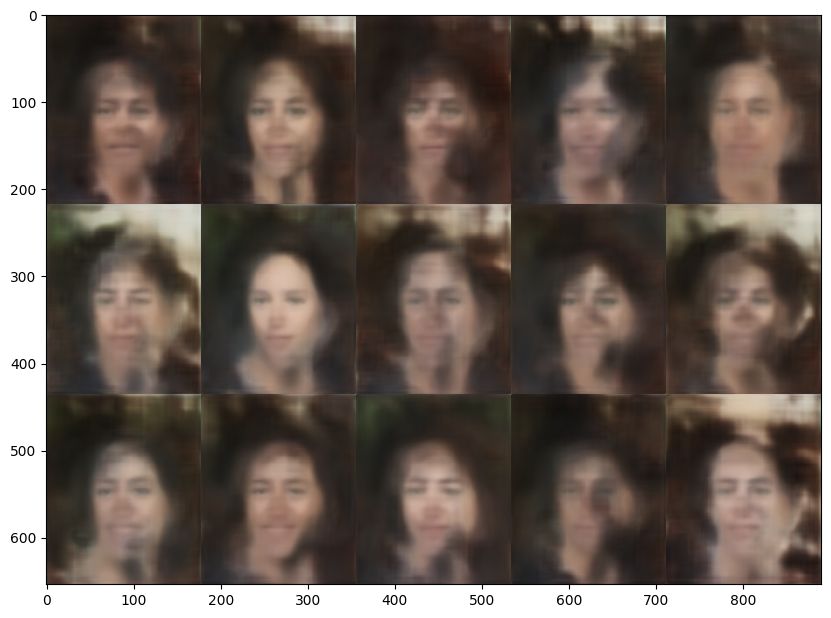

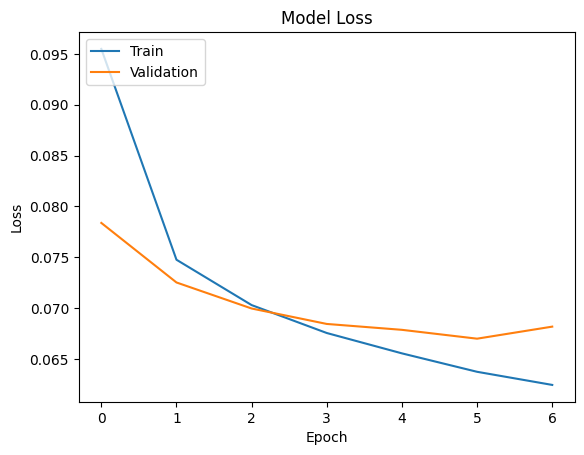

In [ ]:
with tf.compat.v1.Session() as sess:
    b_size = 128
    n_size = 512
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape = (n_size,) , mean = 0, stddev = 1)
        return z_mean + K.exp(z_log_sigma/2) * epsilon

    def build_conv_vae(input_shape, bottleneck_size, sampling, batch_size = 32):
      # ENCODER
        input = Input(shape=(input_shape[0],input_shape[1],input_shape[2]))
        x = Conv2D(32,(3,3),activation = 'relu', padding = 'same')(input)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2), padding ='same')(x)
        x = Conv2D(64,(3,3),activation = 'relu', padding = 'same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2), padding ='same')(x)
        x = Conv2D(128,(3,3), activation = 'relu', padding = 'same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2), padding ='same')(x)
        x = Conv2D(256,(3,3), activation = 'relu', padding = 'same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2), padding ='same')(x)

        # Latent Variable Calculation
        shape = K.int_shape(x)
        flatten_1 = Flatten()(x)
        dense_1 = Dense(bottleneck_size, name='z_mean')(flatten_1)
        z_mean = BatchNormalization()(dense_1)
        flatten_2 = Flatten()(x)
        dense_2 = Dense(bottleneck_size, name ='z_log_sigma')(flatten_2)
        z_log_sigma = BatchNormalization()(dense_2)
        z = Lambda(sampling)([z_mean, z_log_sigma])
        encoder = Model(input, [z_mean, z_log_sigma, z], name = 'encoder')

        # DECODER
        latent_input = Input(shape=(bottleneck_size,), name = 'decoder_input')
        x = Dense(shape[1]*shape[2]*shape[3])(latent_input)
        x = Reshape((shape[1],shape[2],shape[3]))(x)
        x = UpSampling2D((2,2))(x)
        x = Cropping2D([[0,0],[0,1]])(x)
        x = Conv2DTranspose(256,(3,3), activation = 'relu', padding = 'same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2,2))(x)
        x = Cropping2D([[0,1],[0,1]])(x)
        x = Conv2DTranspose(128,(3,3), activation = 'relu', padding = 'same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2,2))(x)
        x = Cropping2D([[0,1],[0,1]])(x)
        x = Conv2DTranspose(64,(3,3), activation = 'relu', padding = 'same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2,2))(x)
        x = Conv2DTranspose(32,(3,3), activation = 'relu', padding = 'same')(x)
        x = BatchNormalization()(x)
        output = Conv2DTranspose(3,(3,3), activation = 'tanh', padding ='same')(x)
        decoder = Model(latent_input, output, name = 'decoder')

        output_2 = decoder(encoder(input)[2])
        vae = Model(input, output_2, name ='vae')
        return vae, encoder, decoder, z_mean, z_log_sigma

    vae_2, encoder, decoder, z_mean, z_log_sigma = build_conv_vae(img_sample.shape, n_size, sampling, batch_size = b_size)
    print("encoder summary:")
    encoder.summary()
    print("decoder summary:")
    decoder.summary()
    print("vae summary:")
    vae_2.summary()

    def vae_loss(input_img, output):
        # Compute error in reconstruction
        reconstruction_loss = mse(K.flatten(input_img) , K.flatten(output))

        # Compute the KL Divergence regularization term
        kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)

        # Return the average loss over all images in batch
        total_loss = (reconstruction_loss + 0.0001 * kl_loss)
        return total_loss
    vae_2.compile(optimizer='rmsprop', loss= vae_loss)
    encoder.compile(optimizer = 'rmsprop', loss = vae_loss)
    decoder.compile(optimizer = 'rmsprop', loss = vae_loss)
    history = vae_2.fit_generator(train_generator, steps_per_epoch = 4000, validation_data = val_generator, epochs=7, validation_steps= 500)

    x_test = []
    for i in range(64):
        x_test.append(get_input(img_path[random.randint(0,len(img_id))]))
    x_test = np.array(x_test)
    figure_Decoded = vae_2.predict(x_test.astype('float32')/127.5 -1, batch_size = b_size)
    figure_decoded = (figure_Decoded[0]+1)/2
    # Display decoder output images with size 128x128
    with zipfile.ZipFile('decoder_output.zip', 'w') as zipf:
      for i in range(5):
        plt.axis('off')
        plt.subplot(2, 5, 2 + i * 2)
        plt.imshow(cv2.resize((figure_Decoded[i] + 1) / 2, (128, 128)))
        plt.axis('off')

        # Simpan gambar ke dalam direktori tujuan
        image_path = f"decoder_output_{i}.png"
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
        plt.close()

        # Menghapus latar belakang putih dari gambar dan menyimpannya
        img = mpimg.imread(image_path)
        img = Image.fromarray((img * 255).astype(np.uint8))
        img = img.convert("RGBA")
        data = np.array(img)
        r, g, b, a = data[:, :, 0], data[:, :, 1], data[:, :, 2], data[:, :, 3]
        mask = (r >= 240) & (g >= 240) & (b >= 240) & (a >= 240)
        data[:, :, :3][mask] = [0, 0, 0]
        img = Image.fromarray(data)
        img.save(image_path)

        # Menambahkan gambar ke dalam file zip
        zipf.write(image_path)

        # Menghapus gambar setelah disimpan dalam file zip
        os.remove(image_path)
    plt.show()

    # Randomly generated 15 images from 15 series of noise information
    n = 3
    m = 5
    digit_size1 = 218
    digit_size2 = 178
    figure = np.zeros((digit_size1 * n, digit_size2 * m,3))

    for i in range(3):
        for j in range(5):
            z_sample = np.random.rand(1,512)
            x_decoded = decoder.predict([z_sample])
            figure[i * digit_size1: (i + 1) * digit_size1,
                   j * digit_size2: (j + 1) * digit_size2,:] = (x_decoded[0]+1)/2
    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.show()
    plt.close()

    #kurva loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    #Menyimpan model vae
    vae_2.save('model_vae.h5')

###Analisis Real Fake Images

####Import Library

In [ ]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
import os
import pandas as pd
import itertools
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
from torchvision import datasets, transforms, models
from tensorflow.keras import layers

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.12.0


####Input dataset form GDrive

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Load Dataset
dataimg = '/content/drive/MyDrive/TA Regina/Dataset/CelebA'
files = os.listdir(dataimg)
images = []
for file in files:
  image = Image.open(os.path.join(dataimg, file))
  image = np.array(image.convert('L'))
  image = cv2.resize(image, (85, 85))
  images.append(image)
images = np.array(images) / 255.0

Mounted at /content/drive


In [ ]:
!unzip decoder_output.zip

Archive:  decoder_output.zip
 extracting: decoder_output/decoder_output_0.png  
 extracting: decoder_output/decoder_output_1.png  
 extracting: decoder_output/decoder_output_10.png  
 extracting: decoder_output/decoder_output_11.png  
 extracting: decoder_output/decoder_output_12.png  
 extracting: decoder_output/decoder_output_13.png  
 extracting: decoder_output/decoder_output_14.png  
 extracting: decoder_output/decoder_output_15.png  
 extracting: decoder_output/decoder_output_16.png  
 extracting: decoder_output/decoder_output_17.png  
 extracting: decoder_output/decoder_output_18.png  
 extracting: decoder_output/decoder_output_19.png  
 extracting: decoder_output/decoder_output_2.png  
 extracting: decoder_output/decoder_output_20.png  
 extracting: decoder_output/decoder_output_21.png  
 extracting: decoder_output/decoder_output_22.png  
 extracting: decoder_output/decoder_output_23.png  
 extracting: decoder_output/decoder_output_24.png  
 extracting: decoder_output/decoder_ou

In [ ]:
!unzip Foto01\ \(2\).zip

Archive:  Foto01 (2).zip
  inflating: Foto01/1.png            
  inflating: Foto01/10.png           
  inflating: Foto01/2.png            
  inflating: Foto01/3.png            
  inflating: Foto01/4.png            
  inflating: Foto01/5.png            
  inflating: Foto01/6.png            
  inflating: Foto01/7.png            
  inflating: Foto01/8.png            
  inflating: Foto01/9.png            


In [ ]:
!unzip Foto02.zip

Archive:  Foto02.zip
  inflating: Foto02/000494.jpg       
  inflating: Foto02/000524.jpg       
  inflating: Foto02/000536.jpg       
  inflating: Foto02/000556.jpg       
  inflating: Foto02/000585.jpg       
  inflating: Foto02/000591.jpg       
  inflating: Foto02/000871.jpg       
  inflating: Foto02/000987.jpg       
  inflating: Foto02/000993.jpg       
  inflating: Foto02/024098.jpg       


In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

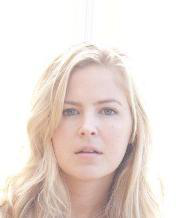

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000871.jpg'
Image.open(image_real)

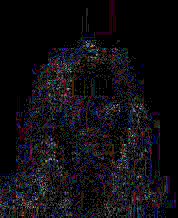

In [ ]:
convert_to_ela_image(image_real, 90)

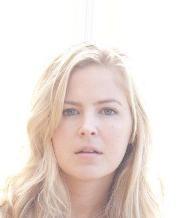

In [ ]:
image_fake = '/content/Foto02/000871.jpg'
Image.open(image_fake)

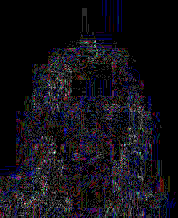

In [ ]:
convert_to_ela_image(image_fake, 90)

####Training & Validation Process

In [ ]:
image_size = (85, 85)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [ ]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [ ]:
import random
path = '/content/drive/MyDrive/TA Regina/Dataset/CelebA'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
500 500


In [ ]:
path = '/content/Foto02'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

510 510


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 85, 85, 3)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

408 408
102 102


#####Build Model Using Cov2D

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (85, 85, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (85, 85, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model
model = build_model()
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 81, 81, 32)        2432      
                                                                 
 conv2d_63 (Conv2D)          (None, 77, 77, 32)        25632     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 38, 38, 32)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 38, 38, 32)        0         
                                                                 
 flatten_20 (Flatten)        (None, 46208)             0         
                                                                 
 dense_40 (Dense)            (None, 256)               11829504  
                                                     

#####Training Process

In [ ]:
epochs = 30
batch_size = 50

In [ ]:
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/9 [======================>.......] - ETA: 0s - loss: 0.3057 - accuracy: 0.9114

9/9 [==============================] - 1s 52ms/step - loss: 0.2813 - accuracy: 0.9191 - val_loss: 0.2230 - val_accuracy: 0.9608
Epoch 2/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0702 - accuracy: 0.9886

9/9 [==============================] - 0s 28ms/step - loss: 0.0975 - accuracy: 0.9853 - val_loss: 0.3108 - val_accuracy: 0.9608
Epoch 3/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0870 - accuracy: 0.9875

9/9 [==============================] - 0s 29ms/step - loss: 0.1052 - accuracy: 0.9853 - val_loss: 0.2723 - val_accuracy: 0.9608
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9853

9/9 [==============================] - 0s 29ms/step - loss: 0.0890 - accuracy: 0.9853 - val_loss: 0.2042 - val_accuracy: 0.9608
Epoch 5/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0841 - accuracy: 0.9850

9/9 [==============================] - 0s 28ms/step - loss: 0.0830 - accuracy: 0.9853 - val_loss: 0.1876 - val_accuracy: 0.9608
Epoch 6/30
9/9 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9853

9/9 [==============================] - 0s 29ms/step - loss: 0.0833 - accuracy: 0.9853 - val_loss: 0.1965 - val_accuracy: 0.9608
Epoch 7/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0789 - accuracy: 0.9857

9/9 [==============================] - 0s 28ms/step - loss: 0.0801 - accuracy: 0.9853 - val_loss: 0.2049 - val_accuracy: 0.9608
Epoch 8/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0759 - accuracy: 0.9857

9/9 [==============================] - 0s 28ms/step - loss: 0.0771 - accuracy: 0.9853 - val_loss: 0.2107 - val_accuracy: 0.9608
Epoch 9/30
9/9 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9853

9/9 [==============================] - 0s 28ms/step - loss: 0.0838 - accuracy: 0.9853 - val_loss: 0.2125 - val_accuracy: 0.9608
Epoch 10/30
9/9 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9853

9/9 [==============================] - 0s 28ms/step - loss: 0.0757 - accuracy: 0.9853 - val_loss: 0.2044 - val_accuracy: 0.9608
Epoch 11/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0752 - accuracy: 0.9850

9/9 [==============================] - 0s 28ms/step - loss: 0.0741 - accuracy: 0.9853 - val_loss: 0.2057 - val_accuracy: 0.9608
Epoch 12/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0599 - accuracy: 0.9886

9/9 [==============================] - 0s 27ms/step - loss: 0.0740 - accuracy: 0.9853 - val_loss: 0.2132 - val_accuracy: 0.9608
Epoch 13/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9829

9/9 [==============================] - 0s 28ms/step - loss: 0.0741 - accuracy: 0.9853 - val_loss: 0.2059 - val_accuracy: 0.9608
Epoch 14/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0788 - accuracy: 0.9829

9/9 [==============================] - 0s 27ms/step - loss: 0.0709 - accuracy: 0.9853 - val_loss: 0.2058 - val_accuracy: 0.9608
Epoch 15/30
9/9 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9853

9/9 [==============================] - 0s 28ms/step - loss: 0.0643 - accuracy: 0.9853 - val_loss: 0.2143 - val_accuracy: 0.9608
Epoch 16/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0744 - accuracy: 0.9829

9/9 [==============================] - 0s 29ms/step - loss: 0.0660 - accuracy: 0.9853 - val_loss: 0.2155 - val_accuracy: 0.9608
Epoch 17/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0542 - accuracy: 0.9886

9/9 [==============================] - 0s 27ms/step - loss: 0.0669 - accuracy: 0.9853 - val_loss: 0.2167 - val_accuracy: 0.9608
Epoch 18/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0593 - accuracy: 0.9850

9/9 [==============================] - 0s 31ms/step - loss: 0.0585 - accuracy: 0.9853 - val_loss: 0.2110 - val_accuracy: 0.9608
Epoch 19/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0409 - accuracy: 0.9914

9/9 [==============================] - 0s 32ms/step - loss: 0.0589 - accuracy: 0.9853 - val_loss: 0.2163 - val_accuracy: 0.9608
Epoch 20/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0607 - accuracy: 0.9886

9/9 [==============================] - 0s 32ms/step - loss: 0.0691 - accuracy: 0.9853 - val_loss: 0.1931 - val_accuracy: 0.9608
Epoch 21/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0672 - accuracy: 0.9829

9/9 [==============================] - 0s 31ms/step - loss: 0.0601 - accuracy: 0.9853 - val_loss: 0.2108 - val_accuracy: 0.9608
Epoch 22/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0539 - accuracy: 0.9857

9/9 [==============================] - 0s 32ms/step - loss: 0.0552 - accuracy: 0.9853 - val_loss: 0.2306 - val_accuracy: 0.9608
Epoch 23/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0604 - accuracy: 0.9829

9/9 [==============================] - 0s 31ms/step - loss: 0.0533 - accuracy: 0.9853 - val_loss: 0.2233 - val_accuracy: 0.9608
Epoch 24/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0425 - accuracy: 0.9875

9/9 [==============================] - 0s 33ms/step - loss: 0.0474 - accuracy: 0.9853 - val_loss: 0.2228 - val_accuracy: 0.9608
Epoch 25/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0482 - accuracy: 0.9850

9/9 [==============================] - 0s 31ms/step - loss: 0.0477 - accuracy: 0.9853 - val_loss: 0.2114 - val_accuracy: 0.9608
Epoch 26/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0465 - accuracy: 0.9850

9/9 [==============================] - 0s 31ms/step - loss: 0.0459 - accuracy: 0.9853 - val_loss: 0.2371 - val_accuracy: 0.9608
Epoch 27/30
8/9 [=========================>....] - ETA: 0s - loss: 0.0429 - accuracy: 0.9850

9/9 [==============================] - 0s 35ms/step - loss: 0.0422 - accuracy: 0.9853 - val_loss: 0.2402 - val_accuracy: 0.9608
Epoch 28/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0445 - accuracy: 0.9829

9/9 [==============================] - 0s 33ms/step - loss: 0.0397 - accuracy: 0.9853 - val_loss: 0.2362 - val_accuracy: 0.9608
Epoch 29/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0322 - accuracy: 0.9886

9/9 [==============================] - 0s 32ms/step - loss: 0.0391 - accuracy: 0.9853 - val_loss: 0.2340 - val_accuracy: 0.9608
Epoch 30/30
7/9 [======================>.......] - ETA: 0s - loss: 0.0422 - accuracy: 0.9886

9/9 [==============================] - 0s 38ms/step - loss: 0.0473 - accuracy: 0.9853 - val_loss: 0.2035 - val_accuracy: 0.9608


In [ ]:
model.save('model_data.h5')

#####Curve Accuracy & Loss

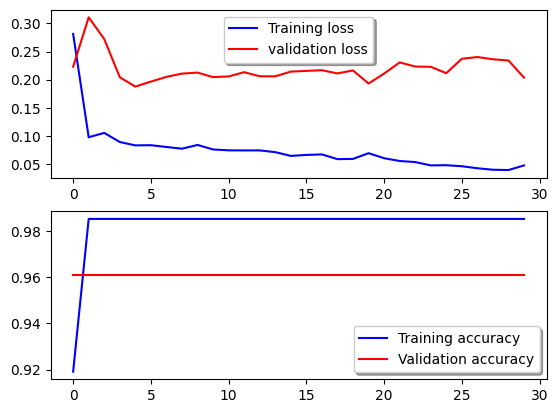

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#####Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

4/4 [==============================] - 0s 4ms/step


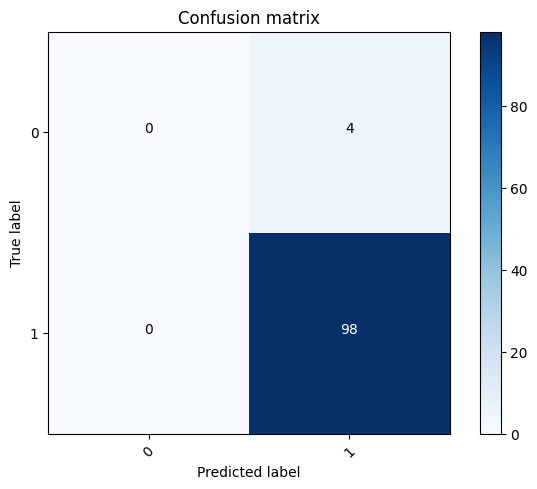

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

####Images Prediction Real vs Fake

In [ ]:
class_names = ['fake', 'real']

#####5 Prediksi Awal

######Prediksi 1

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/024069.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 210ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto01/1.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 27ms/step
Class: fake Confidence: 51.26


######Prediksi 2

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000019.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto01/2.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: fake Confidence: 50.03


######Prediksi 3

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000023.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 30ms/step
Class: real Confidence: 99.99


In [ ]:
image_fake = '/content/Foto01/3.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 24ms/step
Class: fake Confidence: 50.11


######Prediksi 4

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000502.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 20ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto01/6.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 29ms/step
Class: real Confidence: 74.71


######Prediksi 5

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000010.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 31ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto01/4.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: real Confidence: 90.02


#####5 Prediksi Tahap 2

######Prediksi 6

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000566.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 26ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto01/7.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: real Confidence: 50.66


######Prediksi 7

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000007.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 28ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto01/5.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 28ms/step
Class: real Confidence: 54.65


######Prediksi 8

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000709.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 23ms/step
Class: fake Confidence: 100.00


In [ ]:
image_fake = '/content/Foto01/8.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: real Confidence: 92.04


######Prediksi 9

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000763.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto01/9.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: fake Confidence: 53.99


######Prediksi 10

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000922.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto01/10.png'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 24ms/step
Class: real Confidence: 98.96


#####5 Prediksi Tahap 3

######Prediksi 11

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000987.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 23ms/step
Class: real Confidence: 98.24


In [ ]:
image_fake = '/content/Foto02/000987.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: real Confidence: 77.29


######Prediksi 12

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/024098.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: real Confidence: 99.06


In [ ]:
image_fake = '/content/Foto02/024098.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: real Confidence: 93.44


######Prediksi 13

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000993.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto02/000993.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: real Confidence: 100.00


######Prediksi 14

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000556.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 22ms/step
Class: real Confidence: 99.96


In [ ]:
image_fake = '/content/Foto02/000556.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 18ms/step
Class: real Confidence: 96.33


######Prediksi 15

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000585.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: real Confidence: 99.29


In [ ]:
image_fake = '/content/Foto02/000585.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 29ms/step
Class: real Confidence: 89.39


#####5 Prediksi Akhir

######Prediksi 16

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000591.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 29ms/step
Class: real Confidence: 99.91


In [ ]:
image_fake = '/content/Foto02/000591.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 18ms/step
Class: real Confidence: 99.96


######Prediksi 17

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000494.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 18ms/step
Class: real Confidence: 99.80


In [ ]:
image_fake = '/content/Foto02/000494.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: real Confidence: 98.12


######Prediksi 18

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000524.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: real Confidence: 99.99


In [ ]:
image_fake = '/content/Foto02/000524.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: real Confidence: 99.99


######Prediksi 19

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000536.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 22ms/step
Class: real Confidence: 100.00


In [ ]:
image_fake = '/content/Foto02/000536.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 20ms/step
Class: real Confidence: 100.00


######Prediksi 20

In [ ]:
image_real = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/000871.jpg'
image = prepare_image(image_real)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 19ms/step
Class: real Confidence: 91.99


In [ ]:
image_fake = '/content/Foto02/000871.jpg'
image = prepare_image(image_fake)
image = image.reshape(-1, 85, 85, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 21ms/step
Class: real Confidence: 75.63


###Get Metadata Image

In [ ]:
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from PIL import Image

# Load pre-trained VGG16 model (or any other DNN model)
model = VGG16(weights='imagenet', include_top=True)

# Path to your image
image_path = '/content/drive/MyDrive/TA Regina/Dataset/CelebA/024069.jpg'

# Load and preprocess the image
img = Image.open(image_path).resize((224, 224))
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Extract metadata using the DNN model
predictions = model.predict(x)
predicted_classes = decode_predictions(predictions, top=3)[0]

# Print the top predicted classes
for _, class_name, probability in predicted_classes:
    print(f"Class: {class_name}, Probability: {probability}")

35363/35363 [==============================] - 0s 0us/step
Class: hair_spray, Probability: 0.14446116983890533
Class: wig, Probability: 0.10143651813268661
Class: brassiere, Probability: 0.04411328583955765


In [ ]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import tensorflow as tf

def vae_loss(input_img, output):
  # Compute error in reconstruction
  reconstruction_loss = mse(K.flatten(input_img) , K.flatten(output))

  # Compute the KL Divergence regularization term
  kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)

  # Return the average loss over all images in batch
  total_loss = (reconstruction_loss + 0.0001 * kl_loss)
  return total_loss

# Memasukkan fungsi kehilangan ke dalam lingkup saat memuat model
with K.name_scope('custom_loss'):
    setattr(K, 'vae_loss', vae_loss)
    with tf.keras.utils.custom_object_scope({'vae_loss': vae_loss}):
        model = load_model('model_vae.h5')

# Path to your generated image
image_path = '/content/decoder_output/decoder_output_32.png'

# Load and preprocess the generated image
img = Image.open(image_path).resize((178, 218))
img = img.convert("RGB")
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalisasi piksel menjadi rentang [0, 1]

# Extract metadata using the VAE model
latent_vector = model.predict(x)

# Print the latent vector
print("Latent vector:", latent_vector)

1/1 [==============================] - 0s 476ms/step
Latent vector: [[[[ 0.34194642  0.29295683  0.38562232]
   [ 0.3406116   0.41167414  0.45834357]
   [ 0.3296742   0.3865769   0.49544847]
   ...
   [ 0.08308347  0.29324964  0.4243016 ]
   [ 0.17610723  0.34438896  0.45191157]
   [ 0.17207271  0.25345626  0.35153407]]

  [[ 0.32347146  0.3852505   0.49102283]
   [ 0.28552386  0.3812217   0.45006323]
   [ 0.29234204  0.3556985   0.4705109 ]
   ...
   [ 0.10527366  0.3757154   0.40410805]
   [ 0.0946621   0.38444102  0.4359939 ]
   [ 0.15850374  0.3328833   0.39249453]]

  [[ 0.24339162  0.40608758  0.4997297 ]
   [ 0.2547087   0.35716572  0.45079768]
   [ 0.2660186   0.3375618   0.44328153]
   ...
   [ 0.15515512  0.30761546  0.42604786]
   [ 0.05484359  0.3798231   0.42791963]
   [ 0.08982831  0.25692594  0.41639754]]

  ...

  [[ 0.37938952  0.30525303  0.34920093]
   [ 0.4070219   0.38372448  0.38540366]
   [ 0.42025417  0.38231516  0.40663046]
   ...
   [ 0.12205626  0.01509102  0

In [ ]:
!pip install exifread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 5.4 MB/s eta 0:00:00


In [ ]:
import exifread
from PIL import Image

# Fungsi untuk membaca metadata EXIF
def read_exif(image_path):
    with open(image_path, 'rb') as f:
        tags = exifread.process_file(f)
    return tags

# Fungsi untuk mendapatkan informasi gambar
def get_image_info(image_path):
    # Membaca metadata EXIF
    exif_tags = read_exif(image_path)

    # Membuka gambar menggunakan PIL
    image = Image.open(image_path)

    # Mendapatkan informasi dasar gambar
    width, height = image.size
    format = image.format
    mode = image.mode

    # Membaca informasi tambahan dari metadata EXIF
    make = exif_tags.get('Image Make')
    model = exif_tags.get('Image Model')
    exposure_time = exif_tags.get('EXIF ExposureTime')
    aperture = exif_tags.get('EXIF FNumber')
    iso = exif_tags.get('EXIF ISOSpeedRatings')

    # Mencetak informasi gambar
    print("Image Path:", image_path)
    print("Width:", width)
    print("Height:", height)
    print("Format:", format)
    print("Mode:", mode)
    print("Make:", make)
    print("Model:", model)
    print("Exposure Time:", exposure_time)
    print("Aperture:", aperture)
    print("ISO:", iso)

# Path ke gambar yang ingin dianalisis
image_path = "/content/decoder_output/decoder_output_32.png"

# Memanggil fungsi untuk mendapatkan informasi gambar
get_image_info(image_path)

Image Path: /content/decoder_output/decoder_output_32.png
Width: 85
Height: 85
Format: PNG
Mode: RGBA
Make: None
Model: None
Exposure Time: None
Aperture: None
ISO: None


In [ ]:
import exifread
from PIL import Image

# Fungsi untuk membaca metadata EXIF
def read_exif(image_path):
    with open(image_path, 'rb') as f:
        tags = exifread.process_file(f)
    return tags

# Fungsi untuk mendapatkan informasi gambar
def get_image_info(image_path):
    # Membaca metadata EXIF
    exif_tags = read_exif(image_path)

    # Membuka gambar menggunakan PIL
    image = Image.open(image_path)

    # Mendapatkan informasi dasar gambar
    width, height = image.size
    format = image.format
    mode = image.mode

    # Membaca informasi tambahan dari metadata EXIF
    make = exif_tags.get('Image Make')
    model = exif_tags.get('Image Model')
    exposure_time = exif_tags.get('EXIF ExposureTime')
    aperture = exif_tags.get('EXIF FNumber')
    iso = exif_tags.get('EXIF ISOSpeedRatings')

    # Mencetak informasi gambar
    print("Image Path:", image_path)
    print("Width:", width)
    print("Height:", height)
    print("Format:", format)
    print("Mode:", mode)
    print("Make:", make)
    print("Model:", model)
    print("Exposure Time:", exposure_time)
    print("Aperture:", aperture)
    print("ISO:", iso)

# Path ke gambar yang ingin dianalisis
image_path = "/content/drive/MyDrive/TA Regina/Dataset/CelebA/024069.jpg"

# Memanggil fungsi untuk mendapatkan informasi gambar
get_image_info(image_path)

Image Path: /content/drive/MyDrive/TA Regina/Dataset/CelebA/024069.jpg
Width: 178
Height: 218
Format: JPEG
Mode: RGB
Make: None
Model: None
Exposure Time: None
Aperture: None
ISO: None
